In [2]:
import os
import pandas as pd
import numpy as np
import re
import h5py
from skimage import io
from scipy.ndimage import gaussian_filter
from datetime import datetime
from tqdm.auto import tqdm

IMG_SHAPE = (1024, 1280)
CHANNELS = ['Actin', 'Tubulin', 'DAPI']
DATA_DIR='BBBC021/data'
str_dtype = h5py.string_dtype(encoding='utf-8')

raw_data_dir = os.path.join(DATA_DIR, 'raw')
images_dir = os.path.join(raw_data_dir, 'images')
illum_dir = os.path.join(DATA_DIR, 'illumination_correction')
hdf5_dir = os.path.join(DATA_DIR, 'hdf5')

if not os.path.exists(illum_dir):
    os.mkdir(illum_dir)
if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

moa_df = pd.read_csv(os.path.join(raw_data_dir, 'BBBC021_v1_moa.csv'))
image_df = pd.read_csv(os.path.join(raw_data_dir, 'BBBC021_v1_image.csv'))
image_df['Image_Metadata_Site'] = image_df.Image_FileName_DAPI.transform(
    lambda x: int(re.search('_s[1-4]_', x).group()[2])
)
image_df = image_df.merge(
    moa_df,
    how='left',
    left_on=['Image_Metadata_Compound', 'Image_Metadata_Concentration'],
    right_on=['compound', 'concentration']
).drop(
    columns=['compound', 'concentration']
).fillna('null')
plates = image_df.Image_Metadata_Plate_DAPI.unique().tolist()
plates_tqdm = tqdm(total=len(plates), desc='Plates', leave=False)
for plate in plates[:3]:
    
    illum_plate_dir = os.path.join(illum_dir, plate)
    if not os.path.exists(illum_plate_dir):
        os.mkdir(illum_plate_dir)

    plate_filename = [
        x
        for x in os.listdir(images_dir)
        if (not x.endswith('.zip'))
        and (plate in x)
    ][0]
    plate_sub_dir = os.path.join(images_dir, plate_filename, plate)

    plate_df = image_df.loc[
        image_df.Image_Metadata_Plate_DAPI == plate
    ]
    n_images = len(plate_df)

    channels_tqdm = tqdm(total=len(CHANNELS), desc='Creating hdf5 dataset', leave=False)
    h5_file_path = os.path.join(hdf5_dir, "{}.h5".format(plate))
    with h5py.File(h5_file_path, "w") as h5_file:
        
        h5_file.attrs['timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        h5_file.attrs['info'] = h5py.version.info
        
        h5_file.create_dataset(
            "images", 
            (n_images, len(CHANNELS)) + IMG_SHAPE,
             np.float16
        )
        h5_file.create_dataset("site", (n_images,), np.uint8)
        h5_file.create_dataset("well", (n_images,), str_dtype)
        h5_file.create_dataset("replicate", (n_images,), np.uint8)
        h5_file.create_dataset("plate", (n_images,), str_dtype)
        h5_file.create_dataset("compound", (n_images,), str_dtype)
        h5_file.create_dataset("concentration", (n_images,), np.float16)
        h5_file.create_dataset("moa", (n_images,), str_dtype)
    
    channels_tqdm.set_description('Channels')
    for c, channel in enumerate(CHANNELS):
        channel_imgs = np.empty((n_images,)+IMG_SHAPE, dtype=np.float16)
        sites_tqdm = tqdm(total=4, desc='Sites', leave=False)
        for site in range(1, 5):
            filenames = plate_df.loc[
                plate_df.Image_Metadata_Site == site,
                'Image_FileName_{}'.format(channel)
            ].tolist()
            filenames_tqdm = tqdm(total=len(filenames), desc='Reading images', leave=False)
            for i, filename in enumerate(filenames):
                img = io.imread(os.path.join(plate_sub_dir, filename)).astype(np.float16)
                channel_imgs[(site-1)*len(filenames)+i] = img
                filenames_tqdm.update(1)
            
            filenames_tqdm.set_description('Computing illumination correction')
            # Apply Gaussian filter of size 500 and rescale
            img_avg = channel_imgs[(site-1)*len(filenames):(site)*len(filenames)].mean(axis=(0))
            img_mask = gaussian_filter(img_avg.astype(np.float32), sigma=500).astype(np.float16)
            robust_min = np.percentile(img_mask[img_mask > 0], 0.02)
            img_mask[img_mask < robust_min] = robust_min
            img_mask = img_mask / robust_min
            # and save resulting image
            img_mask_path = os.path.join(illum_plate_dir, '{}_s{}.npy'.format(channel, site))
            np.save(img_mask_path, img_mask)
            
            # apply illumination correction
            channel_imgs[(site-1)*len(filenames):(site)*len(filenames)] = \
                channel_imgs[(site-1)*len(filenames):(site)*len(filenames)] /\
                img_mask
            
            filenames_tqdm.close()
            sites_tqdm.update(1)

        sites_tqdm.set_description('Scaling pixel values')
        low = np.percentile(channel_imgs, 0.2)
        high = np.percentile(channel_imgs, 99.8)
        channel_imgs = (channel_imgs - low) / (high - low)
        channel_imgs = np.clip(channel_imgs, 0, 1)
        
        sites_tqdm.set_description('Saving preprocessed images')
        with h5py.File(h5_file_path, 'a') as h5_file:
            h5_file['images'][:, c, ...] = channel_imgs
            
        sites_tqdm.close()
        channels_tqdm.update(1)
    
    channels_tqdm.set_description('Saving metadata')
    with h5py.File(h5_file_path, 'a') as h5_file:
        for s in range(1, 5):
            site_df = plate_df.loc[
                plate_df.Image_Metadata_Site == s
            ]
            h5_file['site'][(s-1)*len(site_df):s*len(site_df)] = site_df.Image_Metadata_Site.values.astype(np.uint8)
            h5_file['well'][(s-1)*len(site_df):s*len(site_df)] = site_df.Image_Metadata_Well_DAPI.values
            h5_file['replicate'][(s-1)*len(site_df):s*len(site_df)] = site_df.Replicate.values.astype(np.uint8)
            h5_file['plate'][(s-1)*len(site_df):s*len(site_df)] = site_df.Image_Metadata_Plate_DAPI.values
            h5_file['compound'][(s-1)*len(site_df):s*len(site_df)] = site_df.Image_Metadata_Compound.values
            h5_file['concentration'][(s-1)*len(site_df):s*len(site_df)] = site_df.Image_Metadata_Concentration.values.astype(np.float16)
            h5_file['moa'][(s-1)*len(site_df):s*len(site_df)] = site_df.moa.values
    channels_tqdm.close()
    plates_tqdm.update(1)
plates_tqdm.set_description('Finalizing')
plates_tqdm.close()

In [4]:
import numpy as np
import h5py
import os
from datetime import datetime

hdf5_dir = 'BBBC021/data/hdf5'
image_df = pd.read_csv(os.path.join('BBBC021/data/raw', 'BBBC021_v1_image.csv'))
n_images = len(image_df)

with h5py.File(os.path.join(hdf5_dir, os.listdir(hdf5_dir)[0]), 'r') as h5_file:
    datasets = {
        x: [h5_file[x].shape, h5_file[x].dtype]
        for x in list(h5_file.keys())
    }

layouts = {
    x: h5py.VirtualLayout(shape=(n_images,) + shape[1:], dtype=dtype)
    for x, (shape, dtype) in datasets.items()
}

for i, filename in enumerate(os.listdir(hdf5_dir)[:3]):
    file_path = os.path.join(hdf5_dir, filename)
    for d, (s, _) in datasets.items():
        layouts[d][i*s[0]:(i+1)*s[0]] = h5py.VirtualSource(file_path, d, s)
        
with h5py.File("bbbc021.h5", "w") as h5_file:
    h5_file.attrs['timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    h5_file.attrs['h5py_info'] = h5py.version.info
    for name, layout in layouts.items():
        h5_file.create_virtual_dataset(name, layout)

In [6]:
os.listdir(hdf5_dir)[:3]

['Week10_40111.h5', 'Week10_40115.h5', 'Week10_40119.h5']

4
G11
1
Week10_40111
DMSO
0.0
DMSO
float32 (3, 1024, 1280) 0.0059929807 0.009697108529508114 0.18054474890232086 0.35132372


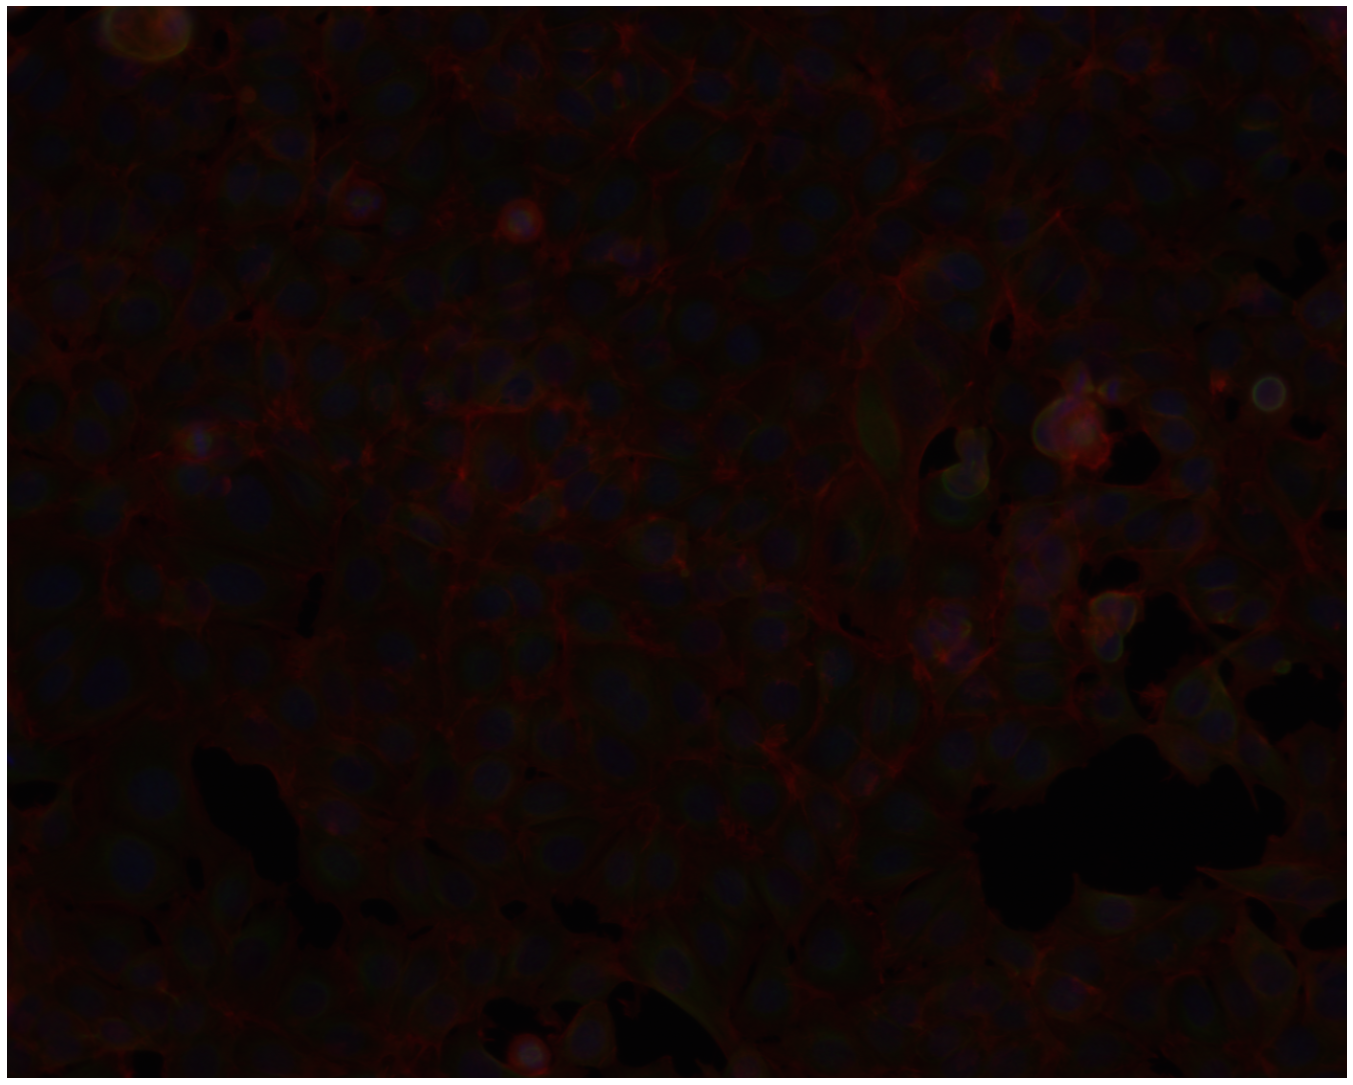

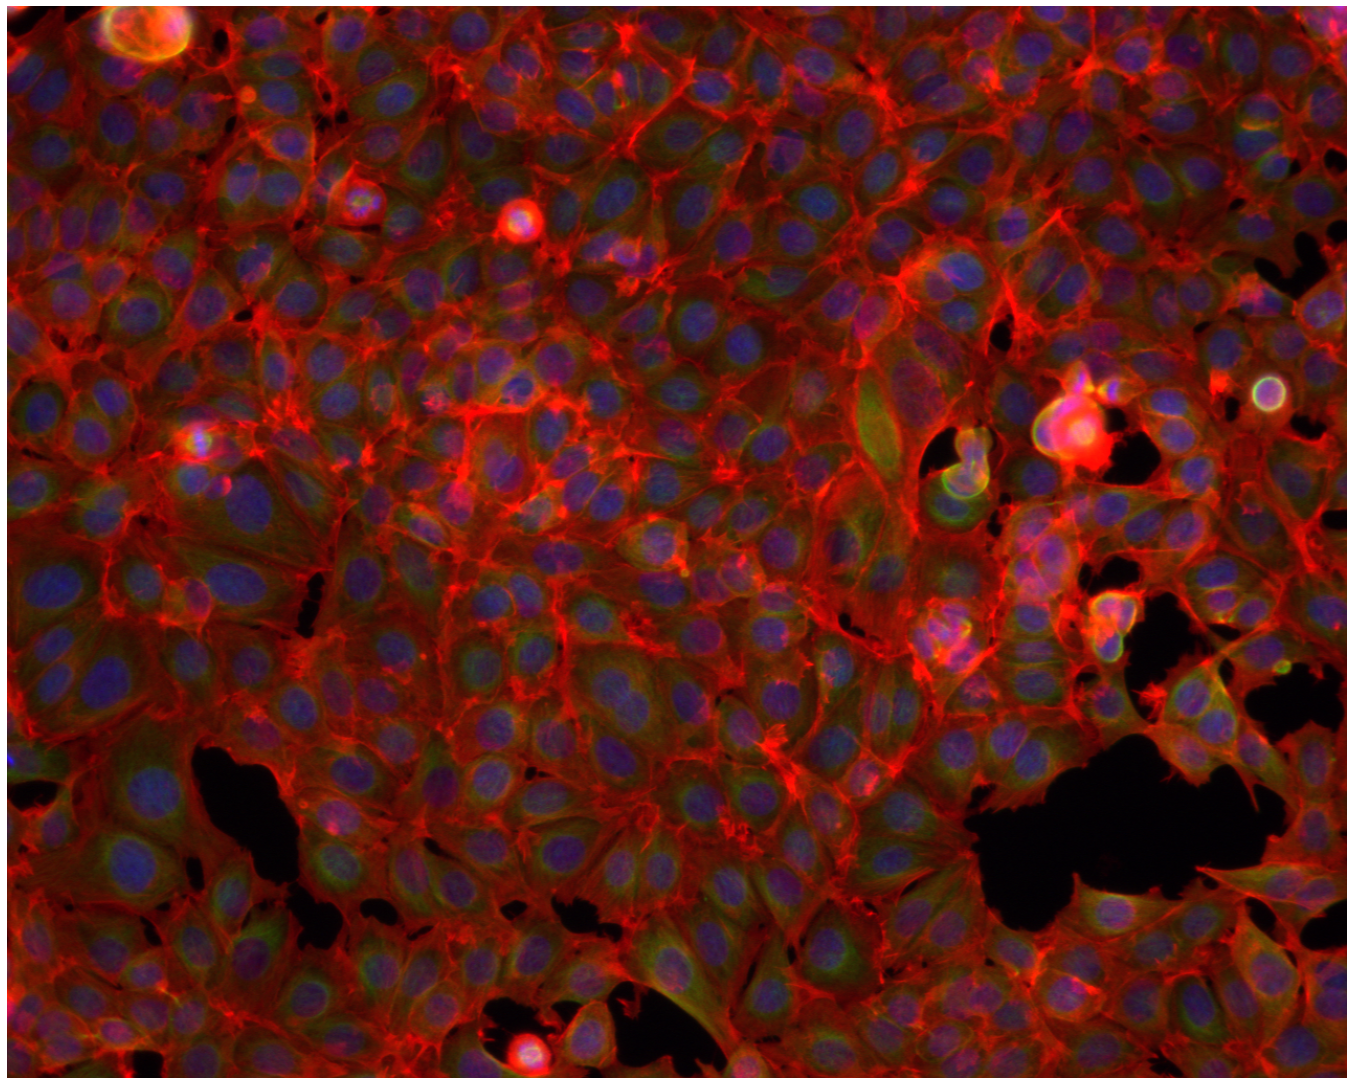

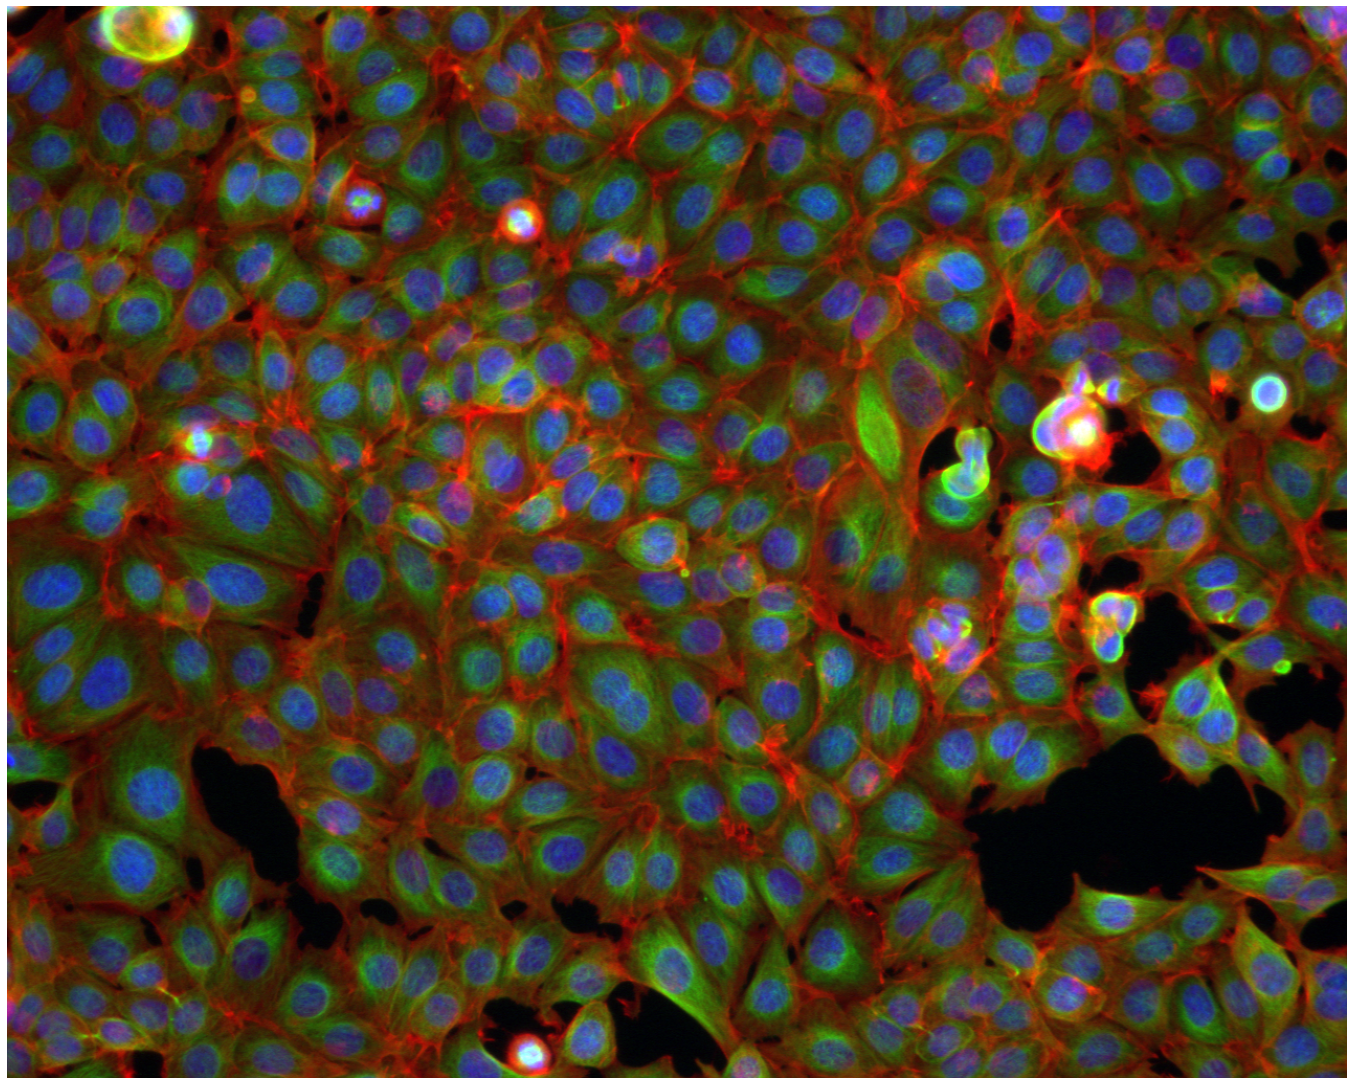

In [5]:
import matplotlib.pyplot as plt
import h5py

with h5py.File("BBBC021/data/hdf5/Week4_27481.h5", "r") as h5_file:
    i = 239
    print(h5_file['site'][i])
    print(h5_file['well'][i])
    print(h5_file['replicate'][i])
    print(h5_file['plate'][i])
    print(h5_file['compound'][i])
    print(h5_file['concentration'][i])
    print(h5_file['moa'][i])
    img = h5_file['images'][i]
    img = img.astype(np.float32) / 65535
    print(img.dtype, img.shape, img.min(), np.percentile(img, 0.2), np.percentile(img, 99.8), img.max())
    
    plt.figure(figsize=(24, 20))
    plt.imshow(np.moveaxis(img, 0, 2))
    plt.axis('off')
    plt.show()
    
    new_img = (img - np.percentile(img, 0.2)) / (np.percentile(img, 99.8) - np.percentile(img, 0.2))
    new_img = np.clip(new_img, 0, 1)
    
    plt.figure(figsize=(24, 20))
    plt.imshow(np.moveaxis(new_img, 0, 2))
    plt.axis('off')
    plt.show()
    
    new_img = img
    for c in range(3):
        new_img[c] = (img[c] - np.percentile(img[c], 0.2)) / (np.percentile(img[c], 99.8) - np.percentile(img[c], 0.2))
    new_img = np.clip(new_img, 0, 1)
    
    plt.figure(figsize=(24, 20))
    plt.imshow(np.moveaxis(new_img, 0, 2))
    plt.axis('off')
    plt.show()